<a href="https://colab.research.google.com/github/karino2/tegashiki/blob/master/tegashiki_mathexp_generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training set generation

symbol rawlist to TFRecord.

In [0]:
import os
import datetime
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import preprocessing
from collections import namedtuple


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
def get_if_necessary(fname):
  if os.path.exists(fname):
    return
  !gsutil cp gs://karino2-tegashiki/dataset/{fname} {fname}

def get_and_load(fname):
  get_if_necessary(fname)
  with gzip.open(fname,'rb') as f:
    return pickle.load(f)  
  
def send_file(fname):
  !gsutil cp {fname} gs://karino2-tegashiki/dataset/
    
def dump_and_send(obj, fname):
  with gzip.open(fname,'wb') as f:
    pickle.dump(obj, f)
  send_file(fname)


In [0]:
BEGIN_OF_SEQ = 113
END_OF_SEQ=112
PAD_TOKEN=0

# +2 is bos, eos
# MAX_TEX_LEN=206+2
# MAX_STROKE_SEQ_LEN=343

VOCAB_SIZE=122


NORMALIZE_MAX=2000

INPUT_TYPE_POINT=1
INPUT_TYPE_SEP=2
INPUT_TYPE_END=0
INPUT_TYPE_PAD=0

# (x, y, TYPE)
INPUT_TYPE_DIM=3

In [5]:
from tqdm.autonotebook import tqdm as tqdmn

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Data setup

In [0]:
def normalize_poslislis(poslislis):
    lislisarr = [np.array(one) for one in poslislis]
    maxpair = [one.max(0) for one in lislisarr]
    minpair = [one.min(0) for one in lislisarr]
    x_max = max(tup[0] for tup in maxpair)
    y_max = max(tup[1] for tup in maxpair)
    x_min = min(tup[0] for tup in minpair)
    y_min = min(tup[1] for tup in minpair)
    ratio = min(NORMALIZE_MAX/(0.0001+x_max-x_min), NORMALIZE_MAX/(0.0001+y_max-y_min))
    res = []
    for one in lislisarr:
      target = one.copy()
      target[:, 0] = (target[:, 0]-x_min)*ratio
      target[:, 1] = (target[:, 1]-y_min)*ratio
      res.append(target)
    return [one.astype(int) for one in res]

In [0]:
def stroke2poslis(strokestr):
   return [(float(pair[0]),float(pair[1])) for pair in [pos.strip().split(" ") for pos in strokestr.split(",")]]

def strokearr2poslislis(strokearr):
  return [stroke2poslis(line) for line in strokearr]

def poslislis2vec(poslislis):
  """To list of 3D vector (x, y, TYPE).
  put (0, 0, INPUT_TYPE_SEP) between stroke.
  put (0, 0, INPUT_TYPE_END) at end.
  """
  res = None
  for one_stroke in poslislis:
    # onestoke (size, 2)
    widen = INPUT_TYPE_POINT*np.ones((one_stroke.shape[0], 3), dtype=int)
    widen[:, :-1] = one_stroke

    # Compare to None cause broadcast for np.array.
    if type(res) != np.ndarray:
      res = np.concatenate((widen, np.array([[0, 0, INPUT_TYPE_SEP]])))
    else:
      res = np.concatenate((res, widen, np.array([[0, 0, INPUT_TYPE_SEP]])))
  res[-1, 2] = INPUT_TYPE_END
  return res

def rawlist2lislislis(raw_list):
  return [strokearr2poslislis(tup["strokes"]) for tup in raw_list]

### Data download

In [0]:
DICT_FILE="dictionary5.txt.gz"

In [0]:
get_if_necessary(DICT_FILE)

One symbol about 300 for train_sym_labels.
30 for valid_sym_labels.

In [0]:
train_sym_labels = get_and_load("crohme2019_subtask_train_labels.pkl.gz")
valid_sym_labels = get_and_load("crohme2019_subtask_valid_labels.pkl.gz")

In [11]:
sum([1 for i in valid_sym_labels if i == 94])

33

In [12]:
sum([1 for i in train_sym_labels if i == 94])

344

In [0]:
with gzip.open(DICT_FILE, "rt") as f:
  sym2id = {tup[0]:int(tup[1]) for tup in [line.rstrip().split() for line in f]}

In [0]:
id2sym = {tup[1]:tup[0] for tup in sym2id.items()}

In [0]:
# train_reduced_lis3
train_strokes_unnom = get_and_load("sym_lis3_50_train.pkl.gz")

#valid_redudced_lis3
valid_strokes_unnom = get_and_load("sym_lis3_50_valid.pkl.gz")

Add mathbbR

In [0]:
train_strokes_mathbbr = get_and_load("sym_lis3_50_mathbbr_train.pkl.gz")
valid_strokes_mathbbr = get_and_load("sym_lis3_50_mathbbr_valid.pkl.gz")

In [0]:
mathbbrId = sym2id["\\mathbb{R}"]

In [0]:
train_sym_labels.extend([mathbbrId]*len(train_strokes_mathbbr))
valid_sym_labels.extend([mathbbrId]*len(valid_strokes_mathbbr))
train_strokes_unnom.extend(train_strokes_mathbbr)
valid_strokes_unnom.extend(valid_strokes_mathbbr)

Other new symbols handling

In [0]:
train_strokes_bmsubseteq = get_and_load("sym_lis3_50_bm_subseteq_train.pkl.gz")
valid_strokes_bmsubseteq = get_and_load("sym_lis3_50_bm_subseteq_valid.pkl.gz")

In [0]:
bmsubseteq_syms = sorted(list(train_strokes_bmsubseteq.keys()))

In [0]:
def extend_syms(sym, train_dic, valid_dic):
  id = sym2id[sym]
  train_sym_labels.extend([id]*len(train_dic[sym]))
  valid_sym_labels.extend([id]*len(valid_dic[sym]))
  train_strokes_unnom.extend(train_dic[sym])
  valid_strokes_unnom.extend(valid_dic[sym])

In [0]:
for sym in bmsubseteq_syms:
  extend_syms(sym, train_strokes_bmsubseteq, valid_strokes_bmsubseteq)

Added data handling

In [0]:
train_strokes_Az = get_and_load("sym_lis3_50_Az_added_train.pkl.gz")
valid_strokes_Az = get_and_load("sym_lis3_50_Az_added_valid.pkl.gz")

In [0]:
Az_syms = sorted(list(train_strokes_Az.keys()))

In [0]:
def extend_syms(sym, train_dic, valid_dic):
  id = sym2id[sym]
  train_sym_labels.extend([id]*len(train_dic[sym]))
  valid_sym_labels.extend([id]*len(valid_dic[sym]))
  train_strokes_unnom.extend(train_dic[sym])
  valid_strokes_unnom.extend(valid_dic[sym])

In [0]:
for sym in Az_syms:
  extend_syms(sym, train_strokes_Az, valid_strokes_Az)

# Data generation

### Utility funcs

In [0]:
def normalize_poslislis(poslislis):
    lislisarr = [np.array(one) for one in poslislis]
    maxpair = [one.max(0) for one in lislisarr]
    minpair = [one.min(0) for one in lislisarr]
    x_max = max(tup[0] for tup in maxpair)
    y_max = max(tup[1] for tup in maxpair)
    x_min = min(tup[0] for tup in minpair)
    y_min = min(tup[1] for tup in minpair)
    ratio = min(NORMALIZE_MAX/(0.0001+x_max-x_min), NORMALIZE_MAX/(0.0001+y_max-y_min))
    res = []
    for one in lislisarr:
      target = one.copy()
      target[:, 0] = (target[:, 0]-x_min)*ratio
      target[:, 1] = (target[:, 1]-y_min)*ratio
      res.append(target)
    return res


In [0]:
def normalize_poslislis_int(poslislis):
  return [one.astype(int) for one in normalize_poslislis(poslislis)]

def normalize_lis3(lis3):
  return [normalize_poslislis(lislis) for lislis in lis3]

In [0]:
train_strokes = normalize_lis3(train_strokes_unnom)
valid_strokes = normalize_lis3(valid_strokes_unnom)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
def listi(lis, pos):
  return np.array([tup[pos] for tup in lis])

def plot_list(lis):
    plt.plot(listi(lis, 0),-listi(lis, 1))
    
def plot_lis2(lislis):
  for i in range(len(lislis)):
    plot_list(lislis[i])


In [0]:
def names2ids(names):
  return [sym2id[name] for name in names]

def names2idset(names):
  return set(names2ids(names))

def ids2names(ids):
  return [id2sym[one] for one in ids]

In [0]:
def match_list(lis, candset):
  """return mask"""
  return [one in candset for one in lis]

def match_list_elem(lis, candelem):
  """return mask"""
  return [one ==candelem for one in lis]

def mask2indices(mask):
  """[True, False, False, True, True] to [0, 3, 4]"""
  return [i for i,one in enumerate(mask) if one]

def mask_list(lis, mask):
  """retrieve subset of list (shorten)."""
  return [tup[0] for tup in zip(lis, mask) if tup[1]]


In [0]:
import random
random.seed(123)

The suffix "\_r" stands for "with random aug".

In [0]:
def scale_lis2(lislis, scale):
  return [scale*one for one in lislis]

def translate_lis2(lislis, dx, dy):
  return [one+(dx, dy) for one in lislis]

def random_aug(rawval):
  # avoid too large augmentation for large raw value. 5 would be enough.
  delta = min(rawval*0.1, 5)
  
  return rawval+random.uniform(-delta, delta)

def scale_lis2_r(lislis, scale_raw):
  scale = random_aug(scale_raw)
  return scale_lis2(lislis, scale)

def translate_lis2_r(lislis, dx_raw, dy_raw):
  dx = random_aug(dx_raw)
  dy = random_aug(dy_raw)
  return translate_lis2(lislis, dx, dy)


In [0]:
def max_common_lis2(lis2, idx):
  return max([arr[:, idx].max() for arr in lis2])

def min_common_lis2(lis2, idx):
  return min([arr[:, idx].min() for arr in lis2])

def max_x_lis2(lis2):
  return max_common_lis2(lis2, 0)

def max_y_lis2(lis2):
  return max_common_lis2(lis2, 1)

def min_x_lis2(lis2):
  return min_common_lis2(lis2, 0)

def min_y_lis2(lis2):
  return min_common_lis2(lis2, 1)

In [0]:
SUBSCRIPT_ID = sym2id["_"]
SUPERSCRIPT_ID = sym2id["^"]

In [0]:
def fit_in_positive_lis2(lislis):
  minx = min_x_lis2(lislis)
  miny = min_y_lis2(lislis)
  if minx > 0 and miny > 0:
    return lislis
  deltax = 0 if minx > 0 else -minx
  deltay = 0 if miny > 0 else -miny
  return translate_lis2(lislis, deltax, deltay)

def augment_lefttop(stroke):
  augleft, augtop = random.uniform(0, 10), random.uniform(0, 10)
  stroke = translate_lis2(stroke, augleft, augtop)
  return fit_in_positive_lis2(stroke)

def post_process(stroke):
  stroke = normalize_poslislis(stroke)
  return augment_lefttop(stroke)


In [0]:
LabelStroke = namedtuple('LabelStroke', ['labels', 'strokes'])

In [0]:
train_ls = LabelStroke(train_sym_labels, train_strokes)
valid_ls = LabelStroke(valid_sym_labels, valid_strokes)

In [0]:
def idset2indicesDict(labels, idset):
  pair = [(id, match_list_elem(labels, id)) for id in idset]
  return {id:mask2indices(mask) for id, mask in pair}

## Dataset generation DSL

xxS ... Pattern sampler. callable with no argument. Return one sample, label-strokes pair.

xxF ... Sampler factory. callable. return xxS.

### DSL implementation

In [0]:
def generate_samples(patS, num):
  res = []
  for i in tqdmn(list(range(num))):
    res.append(patS())
  return res

def check(pair):
  l1, s1 = pair
  print([id2sym[id] for id in l1])
  plot_lis2(s1)

In [0]:
class OneSampler:
  def __init__(self, labelstroke, all_ids):
    self.ls = labelstroke
    self.id2indices = idset2indicesDict(self.ls.labels, all_ids)
  def choose_one(self, ids):
    one_id = random.choice(ids)
    one_idx = random.choice(self.id2indices[one_id])
    return ([self.ls.labels[one_idx]], self.ls.strokes[one_idx])
  
  

In [0]:
def OneOfIdsF(ids):
  return lambda: g_sampler.choose_one(ids)


def OneOfNamesF(names):
  ids = names2ids(names)
  return OneOfIdsF(ids)

In [0]:
def next_to(lis2):
  return max_x_lis2(lis2)+30

def centering_y(strokes):
  height = height_of(strokes)
  if height < 1500:
    y = NORMALIZE_MAX/2 - height/2
    strokes = translate_to(strokes, 0, y)
  return strokes

# easier to read name.
height_of = bottom_of = max_y_lis2
top_of = min_y_lis2
scale_to = scale_lis2_r
translate_to = translate_lis2_r

In [0]:
def TwoTermF(firstS, secondS):
  def twotermS():
    l1, s1 = firstS()
    l2, s2 = secondS()
    
    left = scale_to(s1, 0.4)    
    right = translate_to(scale_to(s2, 0.4), next_to(left), 0)
    
    stroke = post_process(left+right)
    
    return [l1+l2, stroke]
  return twotermS

In [0]:
def SubscF(baseS, termS):
  def subscS():
    lbase, sbase = baseS()
    lterm, sterm = termS()
    
    base1 = scale_to(sbase, 0.5)
    
    subleft = next_to(base1)
    subtop = bottom_of(base1)-200
    sub2 = translate_to(scale_to(sterm, 0.2), subleft, subtop)

    stroke = post_process(base1+sub2)
    syms = lbase+ [SUBSCRIPT_ID] + lterm
    return [syms, stroke]
  return subscS
    

In [0]:
def SupscF(baseS, termS):
  def supscS():
    lbase, sbase = baseS()
    lterm, sterm = termS()
    
    base1 = scale_to(sbase, 0.5)
    sup2 = scale_to(sterm, 0.2)
    
    basetop = height_of(sup2)/2
    supleft = next_to(base1)
        
    base1 = translate_to(base1, 0, basetop)
    sup2 = translate_to(sup2, supleft, 0)

    stroke = post_process(base1+sup2)
    syms = lbase+ [SUPERSCRIPT_ID] + lterm
    return [syms, stroke]
  return supscS
    

In [0]:
def CommaF(baseS, commaS):
  def commaExpS():
    lbase, sbase = baseS()
    lcomma, scomma = commaS()
    
    base1 = scale_to(sbase, 0.9)
    scomma = scale_to(scomma, 0.1)
    
    commaleft = next_to(base1)+100
    commatop = bottom_of(base1)-20
    scomma2 = translate_to(scomma, commaleft, commatop)

    stroke = post_process(base1+scomma2)
    syms = lbase + lcomma
    return [syms, stroke]
  return commaExpS
    

In [0]:
def TransformF(baseS, transformer):
  def transfomS():
    lbase, sbase = baseS()
    sbase = transformer(sbase)
    return [lbase, sbase]
  return transfomS   

In [0]:
def CenterYF(baseS):
  return TransformF(baseS, centering_y)

def ScaleF(baseS, scale):
  scaler = lambda strokes: scale_to(strokes, scale)
  return TransformF(baseS, scaler)

def MoveLeftF(baseS, deltaX):
  shifter = lambda strokes: translate_to(strokes, deltaX, 0)
  return TransformF(baseS, shifter)

def MoveTopF(baseS, deltaY):
  shifter = lambda strokes: translate_to(strokes, 0, deltaY)
  return TransformF(baseS, shifter)


In [0]:
import itertools
from functools import reduce

In [0]:
def OrF(*args):
  """args: list of [(weight1, sampler1), (w2, s2), (w3, s3)...]"""
  accumweights = list(itertools.accumulate(tup[0] for tup in args))
  slist = [tup[1] for tup in args]
  def OrS():
    ones = random.choices(slist, cum_weights=accumweights)
    return ones[0]()
  return OrS

In [0]:
def HoriF(*args):
  "Horizontal"
  def horiS():
    pairs = [samp() for samp in args]
    layouted = [centering_y(pairs[0][1])]
    for idx,pair in enumerate(pairs[1:]):        
      layouted.append(translate_to(centering_y(pair[1]), next_to(layouted[idx])+1000, 0))

    strokes = reduce(lambda acc, strk: acc+strk, layouted)
    syms = reduce(lambda acc, tup: acc+tup[0], pairs, [])  
      
    strokes = post_process(strokes)
    
    return [syms, strokes]
  return horiS


def HoriAlignTopF(*args):
  "Horizontal"
  def horiS():
    pairs = [samp() for samp in args]
    layouted = [centering_y(pairs[0][1])]
    top = top_of(layouted[0])
    for idx,pair in enumerate(pairs[1:]):        
      layouted.append(translate_to(pair[1], next_to(layouted[idx])+1000, top))

    strokes = reduce(lambda acc, strk: acc+strk, layouted)
    syms = reduce(lambda acc, tup: acc+tup[0], pairs, [])  
      
    strokes = post_process(strokes)
    
    return [syms, strokes]
  return horiS

In [0]:
char_names = ["A","B","C","E","F","G","H","I","L","M","N", 
              "P","R", "S","T","V","X","Y",
              "a","b", "c","d", "e", "f","g","h", "i", 
              "j","k","l","m", "n","o","p","q","r","s","t", "u",
              "v","w","x","y", "z",
              "\\alpha","\\beta","\\gamma","\\phi","\\mu",
              "\\lambda","\\sigma", "\\pi", "\\theta"]
binop_names = ["+", "-", "\\times", "\\div", "\\pm"]
eqop_names = ["\\geq", ">", "\\leq", "<", "="]
nonzero_num_names = [str(i) for i in range(1, 10)]
num_names = [str(i) for i in range(0, 10)]
vector_names = ["\\bm{b}", "\\bm{c}", "\\bm{p}", "\\bm{q}", "\\bm{r}", "\\bm{x}"]
other_names = ["\\mathbb{R}", "\\in", "\\subseteq", "\\{", "\\}", ",", "\\ldots"]

In [56]:
sum([1 for id in train_sym_labels if id == sym2id['\\in']])

30

In [0]:
# asterisk not exists!
#sum([1 for id in train_sym_labels if id == sym2id['*']])

# Pattern 3 Generation by DSL

In [0]:
all_idset = names2ids(set(char_names +binop_names + eqop_names + num_names +
                vector_names+other_names))

In [0]:
g_sampler = OneSampler(train_ls, all_idset)

### Rn special handling

R^n would be generated in standard SupS, but we wanto to raise probability of R^1, R^2, R^n, R^m and so on.

In [0]:
MathbbrS = OneOfNamesF(["\\mathbb{R}"])
SupOfRnS = OneOfNamesF(nonzero_num_names+ ["n", "m"])
RnS = SupscF(MathbbrS, SupOfRnS)

### One symbol case

To recognize all one symbol for final backup case.

In [0]:
OneSymbolS = OneOfNamesF(num_names+char_names+vector_names+eqop_names+binop_names+other_names)

## Linear Programming


Expression like
`3x + 4y = `


This pattern also contains

- Just one symbol
- Sup, Sub
- TwoTerm

Just one symbol is some overlap between OneSymbolS, but I think it's natural probability assignment.

### Superscript

Sometimes, L and 2 is hard to distinguish.
But when superscript, most of the time symbol would be 2. So assign more prob for number.

For transporse, T is often used.

Asterisk is often used to denote some special meaning. (p.s. But in our dataset, asterisk does not exists, so skip in pattern3...)

In [0]:
BaseS = OneOfNamesF(char_names + vector_names)

In [0]:
SupscSymS = OrF([0.9, OneOfNamesF(num_names+ ["T"])], [0.1, OneOfNamesF(char_names)])

In [0]:
SupS = SupscF(BaseS, SupscSymS)

### Subscript

In [0]:
SubS = SubscF(BaseS, OneOfNamesF(num_names+ char_names))

### TwoTerm

In [0]:
MultiplierS = OrF([0.33, OneOfNamesF(nonzero_num_names+["a", "b", "c", "d", "x", "y", "A", "B", "C"])],
                  [0.33, SupS],
                  [0.33, SubS])
TwoTermS = TwoTermF(MultiplierS, OrF([0.33, OneOfNamesF(char_names+vector_names)],
                                    [0.33, SupS],
                                    [0.33, SubS]))

### Linear programming

For binop, div is bad dataset quality and do not use much for a while.
pm is not use much.

So the prob distribution is

- +, -, times .. 0.9
- div ... 0.05
- pm ... 0.05

In [0]:
normalBinOpS = OneOfNamesF(['+', '-', '\\times'])
rareBinOpS = OneOfNamesF(['\\div', '\\pm'])

In [0]:
BinopRawS = OrF([0.9, normalBinOpS],
               [0.1, rareBinOpS])

For eqop, we use = much more than other inequality.
So the ratio is

- = ... 0.5
- other ... 0.5

In [0]:
otherEqOpNames = list(set(eqop_names).difference(set(["="])))

In [0]:
equalEqOpS = OneOfNamesF(["="])
otherEqOpS = OneOfNamesF(otherEqOpNames)

In [0]:
EqopRawS = OrF([0.5, equalEqOpS],
              [0.5, otherEqOpS])

In [0]:
BinopS = ScaleF(BinopRawS, 0.6)
EqopS = ScaleF(EqopRawS, 0.6)

In [0]:
OneTermS = OrF(
    [0.33, OneOfNamesF(num_names + char_names+vector_names)],
    [0.33, SupS],
    [0.33, SubS]
)

In [0]:
TermS = OrF(
    [0.3, TwoTermS],
    [0.7, OneTermS]
)

In [0]:
OneBinopS = HoriF(TermS, BinopS)
BinopOneS = HoriF(BinopS, TermS)


In [0]:
OneBinopOneS = HoriF(TermS, BinopS, TermS)

In [0]:
EqExpS = HoriF(TermS, BinopS, TermS, MoveLeftF(EqopS, 1000))

In [0]:
LinearProgramS = OrF([0.3, EqExpS],
                    [0.2, OneBinopOneS],
                    [0.1, OneBinopS],
                    [0.1, BinopOneS],
                    [0.3, TermS])

### In

In [0]:
RightInS = OrF([0.33, MathbbrS], [0.4, RnS], [0.16, OneOfNamesF(["\\{"])],
              [0.1, OneOfNamesF(["A", "B", "C", "E","F", "G", "H", "I","L", "M", "N", "V"])])
InExpS = HoriF(ScaleF(OneOfNamesF(["\\in"]), 0.6), RightInS)

### Subseteq

In [0]:
SubseteqS = HoriF(ScaleF(OneOfNamesF(["\\subseteq"]), 0.6),
                  OrF([0.5, OneOfNamesF(["\\{"])],
                               [0.3, OneOfNamesF(["A", "B", "C"])],
                                [0.1, MathbbrS],
                                [0.1, RnS]))

### Comma, ldots, set

Support {1, 2, ..., n}.
Break down to following.

- {1,
- {1
- 1,
- 1, 2
- 1, 2,
- , ... ,
- ... ,

First, comma expression.

- 1,
- 1, 2
- 1, 2,

In [0]:
commaS = OneOfNamesF([","])

In [0]:
commaBaseS = OrF([0.9, OneOfNamesF(num_names+["x", "y"])], [0.1, SubS])

In [0]:
CommaExpS = CommaF(commaBaseS, commaS)

In [0]:
CommaTwoExpS = HoriF(CommaExpS, MoveLeftF(CommaExpS, 250))

In [0]:
OneCommaOneExpS = HoriF(CommaExpS, MoveLeftF(ScaleF(commaBaseS, 0.9), 250))

Ldots expression
- , ... ,
- ... ,

In [0]:
CommaLdotsCommaS = HoriAlignTopF(commaS, OneOfNamesF(["\\ldots"]), commaS)

In [0]:
LdotsCommaS = HoriAlignTopF(OneOfNamesF(["\\ldots"]), commaS)

Left brace

- {1
- {1,

In [0]:
lBraceS = OneOfNamesF(["\\{"])

In [0]:
LBraceOneS = HoriF(lBraceS, MoveLeftF(ScaleF(commaBaseS, 0.9), -600))

In [0]:
LBraceOneCommaExpS = HoriF(lBraceS, MoveLeftF(CommaExpS, -600))

In [0]:
CommaLDotsSetS = OrF(
    [0.1, CommaExpS],
    [0.1, OneCommaOneExpS],
    [0.2, CommaTwoExpS],
    [0.2, CommaLdotsCommaS],
    [0.1, LdotsCommaS],
    [0.1, LBraceOneS],
    [0.2, LBraceOneCommaExpS]    
)

### Check pattern strokes

In [0]:
labels, strokes = LBraceOneS()

In [0]:
plot_lis2(strokes)

In [160]:
[id2sym[id] for id in labels]

['2', ',', '0', ',']

### Pattern 3.

In [0]:
Pattern3S = OrF(
    [0.125, OneSymbolS],
    [0.025, RnS],
    [0.5, LinearProgramS], 
    [0.025, InExpS],
    [0.025, SubseteqS],
    [0.3, CommaLDotsSetS]
)

pattern1 was 240k. How about twice, 500k? validation set was 24k, so 50k?

In [0]:
random.seed(123)

about 3 min

In [95]:
%%time
all_trains = generate_samples(Pattern3S, 500000)


CPU times: user 3min 10s, sys: 2.77 s, total: 3min 13s
Wall time: 3min 13s


In [96]:
all_trains[0][0], all_trains[1][0]

#expected ([69], [80, 75, 8])

([69], [80, 75, 8])

In [97]:
dump_and_send(all_trains, "pattern3_train_list.pkl.gz")

Copying file://pattern3_train_list.pkl.gz [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/693.3 MiB.                                    


In [0]:
g_sampler = OneSampler(valid_ls, all_idset)

In [0]:
random.seed(456)

In [104]:
all_valids = generate_samples(Pattern3S, 50000)

In [105]:
all_valids[0][0], all_valids[1][0]
# expected ([32, 29, 7], [60, 114, 75, 106])

([32, 29, 7], [60, 114, 75, 106])

In [106]:
dump_and_send(all_valids, "pattern3_valid_list.pkl.gz")

Copying file://pattern3_valid_list.pkl.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/52.7 MiB.                                     


## Pattern 2

### As pattern 1

In [0]:
char_ids = names2ids(char_names)
nonzero_num_ids = names2ids(nonzero_num_names)
num_ids = names2ids(num_names)
binop_ids = names2ids(binop_names)
eqop_ids = names2ids(eqop_names)
vector_ids = names2ids(vector_names)

In [0]:
CategoryIds = namedtuple('CategoryIds', ['char', 'nonzero_num', 'num', 'binop', 'eqop', "vector"])
catids = CategoryIds(char_ids, nonzero_num_ids, num_ids, binop_ids, eqop_ids, vector_ids)
all_idset = set(id for idset in catids for id in idset) | set(names2ids(["\\mathbb{R}", "\\in", "\\subseteq", "\\{", "\\}", ",", "\\ldots"]))

In [0]:
g_sampler = OneSampler(train_ls, all_idset)

In [0]:
NonzeroNumS = OneOfIdsF(catids.nonzero_num)
NumS = OneOfIdsF(catids.num)
CharS = OneOfIdsF(catids.char)

NumCharS = OneOfIdsF(list(set(catids.num + catids.char)))


SubS = SubscF(CharS, NumCharS)
SupS = SupscF(CharS, NumCharS)
TwoTermS = TwoTermF(NumCharS, CharS)

### Rn special handling

R^n would be generated in standard SupS, but we wanto to raise probability of R^1, R^2, R^n, R^m and so on.

In [0]:
MathbbrS = OneOfNamesF(["\\mathbb{R}"])
SupOfRnS = OneOfNamesF(nonzero_num_names+ ["n", "m"])
RnS = SupscF(MathbbrS, SupOfRnS)

### One symbol case

One symbol training set.
Contains eqop by usecase point of view.

In [0]:
OneSymbolS = OneOfIdsF(list(set(catids.num + catids.char + catids.eqop + [mathbbrId])))

### Linear programming

For binop, div is bad dataset quality and do not use much for a while.
pm is not use much.

So the prob distribution is

- +, -, times .. 0.9
- div ... 0.05
- pm ... 0.05

In [0]:
normalBinOpS = OneOfNamesF(['+', '-', '\\times'])
rareBinOpS = OneOfNamesF(['\\div', '\\pm'])

In [0]:
BinopRawS = OrF([0.9, normalBinOpS],
               [0.1, rareBinOpS])

For eqop, we use = much more than other inequality.
So the ratio is

- = ... 0.5
- other ... 0.5

In [0]:
otherEqOpNames = list(set(eqop_names).difference(set(["="])))

In [0]:
equalEqOpS = OneOfNamesF(["="])
otherEqOpS = OneOfNamesF(otherEqOpNames)

In [0]:
EqopRawS = OrF([0.5, equalEqOpS],
              [0.5, otherEqOpS])

In [0]:
BinopS = ScaleF(BinopRawS, 0.6)
EqopS = ScaleF(EqopRawS, 0.6)

In [0]:
termBaseS = OrF(
    [0.33, CharS],
    [0.33, SupS],
    [0.33, SubS]
)

In [0]:
oneTermS = OrF(
    [0.3, TwoTermF(NonzeroNumS, termBaseS)],
    [0.7, termBaseS]
)

In [0]:
OneBinopOneS = HoriF(oneTermS, BinopS, oneTermS)

In [0]:
EqExpS = HoriF(oneTermS, BinopS, oneTermS, MoveLeftF(EqopS, 1000))

### Pattern 2.

EqExpS contains almost all pattern. But it might be too difficult.

I set ratio as

- other 0.5
- OneBinopOneS 0.2
- EqExpS 0.3

For other, I guess OneSymbolS is most important for training.
So I set ratio as (total is not 1, but it's OK)

- OneSymbolIS 0.3
- SubS 0.2
- SupS 0.2
- TwoTermS 0.2
- RnS 0.05

In [0]:
Pattern2S = OrF(
    [0.15, OneSymbolS],
    [0.025, RnS],
    [0.1, SubS],
    [0.1, SupS],
    [0.1, TwoTermS],
    [0.2, OneBinopOneS],
    [0.3, EqExpS]
)

pattern1 was 240k. How about twice, 500k? validation set was 24k, so 50k?

In [0]:
random.seed(123)

In [0]:
all_trains = generate_samples(Pattern2S, 500000)

In [0]:
all_trains[0][0], all_trains[1][0]

#old expected ([21], [112, 47, 92])
#expected ([21], [16, 47, 69])

([21], [16, 47, 69])

In [0]:
# dump_and_send(all_trains, "pattern2_train_list.pkl.gz")

Copying file://pattern2_train_list.pkl.gz [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/861.4 MiB.                                    


In [0]:
g_sampler = OneSampler(valid_ls, all_idset)

In [0]:
random.seed(456)

In [0]:
all_valids = generate_samples(Pattern2S, 50000)

In [0]:
all_valids[0][0], all_valids[1][0]
# expected ([107, 75, 76, 89, 96, 47, 70, 1], [72, 75, 55, 89, 37, 81, 3])

([107, 75, 76, 89, 96, 47, 70, 1], [72, 75, 55, 89, 37, 81, 3])

# Pattern 1 generation

In [0]:
def supsc(sym1, sym2, lislis1, lislis2):
  base_scale = 0.5 + random.uniform(-0.1, 0.1)
  sup_scale = 0.2+ random.uniform(-0.05, 0.05)

  base1 = scale_lis2(lislis1, base_scale)
  sup2 = scale_lis2(lislis2, sup_scale)
  
  basetop = max_y_lis2(sup2)/2+random.uniform(-5., 5.)
  supleft = max_x_lis2(base1)+random.uniform(-5., 5.)+30
  
  base1 = translate_lis2(base1, 0, basetop)
  sup2 = translate_lis2(sup2, supleft, 0)
  
  stroke = post_process(base1+sup2)
  syms = [sym1, SUPERSCRIPT_ID, sym2]
  return syms, stroke

In [0]:
def subsc(sym1, sym2, lislis1, lislis2):
  base_scale = 0.5 + random.uniform(-0.1, 0.1)
  sub_scale = 0.2+ random.uniform(-0.05, 0.05)

  base1 = scale_lis2(lislis1, base_scale)
  subleft = max_x_lis2(base1)+random.uniform(-5., 5.)+30
  subtop = max_y_lis2(base1)+random.uniform(-5., 5.)-200
  sub2 = translate_lis2(scale_lis2(lislis2, sub_scale), subleft, subtop)
  
  stroke = post_process(base1+sub2)  
  syms = [sym1, SUBSCRIPT_ID, sym2]
  return syms, stroke

In [0]:
def two_term(sym1, sym2, lislis1, lislis2):
  left_scale = 0.4 + random.uniform(-0.05, 0.05)
  right_scale = 0.4+ random.uniform(-0.05, 0.05)

  left = scale_lis2(lislis1, left_scale)
  right_x = max_x_lis2(left)+random.uniform(-5., 5.)+30
  right_top = random.uniform(-10., 10.)
  right = translate_lis2(scale_lis2(lislis2, right_scale), right_x, right_top)
  
  stroke = post_process(left+right)
  syms = [sym1, sym2]
  return syms, stroke

In [0]:
def idset2indices(labels, idset):
  mask = match_list(labels, idset)
  return mask2indices(mask)

In [0]:
class DatasetFactory:
  def __init__(self, labelstroke, char_ids, nonzero_num_ids, num_ids):
    self.ls = labelstroke
    
    self.char_indices = idset2indices(self.ls.labels, char_ids)
    self.nonzer_num_indices = idset2indices(self.ls.labels, nonzero_num_ids)
    self.num_indices = idset2indices(self.ls.labels, num_ids)
    self.numchar_indices = idset2indices(self.ls.labels, char_ids|num_ids)
  def _bin_op(self, binop, indices1, indices2, num):
    """binop(sym1, sym2, st1, st2)"""
    term1ids = random.choices(indices1, k=num)
    term2ids = random.choices(indices2, k=num)
    def binop_ids(baseid, subid):
      basesym, basest = self.ls.labels[baseid], self.ls.strokes[baseid]
      subsym, subst =  self.ls.labels[subid], self.ls.strokes[subid]
      return binop(basesym, subsym, basest, subst)
    return [binop_ids(t1, t2) for t1,t2 in zip(term1ids, term2ids)]
  
  def subsc(self, num):
    return self._bin_op(subsc, self.char_indices, self.numchar_indices, num)
  
  def supsc(self, num):
    return self._bin_op(supsc, self.char_indices, self.numchar_indices, num)
  def two_term(self, num):
    # num num is also OK. But we start from much standard case.
    return self._bin_op(two_term, self.numchar_indices, self.char_indices, num)
  def one_symbol_dataset(self):
    one_syms = random.sample(self.numchar_indices, k=len(self.numchar_indices))
    return [[[self.ls.labels[one]], self.ls.strokes[one]] for one in one_syms]

    


In [0]:
fac = DatasetFactory(train_ls, char_ids, nonzero_num_ids, num_ids)

### Generate actual data

For training set.

- all one symbol data (about 58k)
- 60k superscript
- 60k subscript
- 60k two term



In [0]:
ONE_CATEGORY_SIZE=60000

In [0]:
one_symboles = fac.one_symbol_dataset()

In [0]:
suplist = fac.supsc(ONE_CATEGORY_SIZE)

In [0]:
sublist = fac.subsc(ONE_CATEGORY_SIZE)

In [0]:
twotermlist = fac.two_term(ONE_CATEGORY_SIZE)

In [0]:
all_data = one_symboles+suplist+sublist+twotermlist

In [0]:
random.shuffle(all_data)

In [0]:
len(all_data)

237805

validationset

- one symbol 5884
- sup, sub, twoterm 6000 each

In [0]:
ONE_VALID_CATEGORY_SIZE=6000

In [0]:
fac_valid = DatasetFactory(valid_ls, char_ids, nonzero_num_ids, num_ids)

In [0]:
v_one_symboles = fac_valid.one_symbol_dataset()

In [0]:
len(v_one_symboles)

5884

In [0]:
v_suplist = fac.supsc(ONE_VALID_CATEGORY_SIZE)

In [0]:
v_sublist = fac.subsc(ONE_VALID_CATEGORY_SIZE)

In [0]:
v_twotermlist = fac.two_term(ONE_VALID_CATEGORY_SIZE)

In [0]:
v_all_data = v_one_symboles+v_suplist+v_sublist+v_twotermlist

In [0]:
random.shuffle(v_all_data)

# Write to TFRecord

### Data convert for TFRecord

In [107]:
# MAX_TOKEN_LEN
max(len(tup[0]) for tup in (all_trains + all_valids))

14

In [0]:
# max len is [x, _, x]. +2 means <sos> + <eos>
# MAX_TOKEN_LEN=3+2
MAX_TOKEN_LEN=14+2

In [0]:
def symslist2decoder_data_nparray(symslist, maxtklen=MAX_TOKEN_LEN):
  decoder_input_data = np.zeros(
      (len(symslist), maxtklen),
      dtype='uint8')
  
  decoder_sparse_target_data = np.zeros(
    (len(symslist), maxtklen),
    dtype='uint8')

  for i, syms in enumerate(symslist):
    seq = [BEGIN_OF_SEQ] + syms + [END_OF_SEQ]
    decoder_input_data[i, 0:len(seq)] =seq
    decoder_sparse_target_data[i, 0:(len(seq)-1)] =  decoder_input_data[i, 1:len(seq)]
  return decoder_input_data, decoder_sparse_target_data

In [0]:
train_symslist = [tup[0] for tup in all_trains]
train_strokes = [tup[1] for tup in all_trains]

In [0]:
train_decoder_input, train_decoder_target= symslist2decoder_data_nparray(train_symslist, MAX_TOKEN_LEN)

### Check MAX_STROKE_NUM, etc.

In [0]:
valid_symslist = [tup[0] for tup in all_valids]
valid_strokes = [tup[1] for tup in all_valids]

In [113]:
# max stroke num
max(len(strokes) for strokes in train_strokes), max(len(strokes) for strokes in valid_strokes)

(27, 20)

MAX_STROKE_NUM is 27

In [0]:
MAX_STROKE_NUM=27

In [115]:
len(train_strokes[0][0])

46

In [0]:
def strokeslist_to_max_stroke_len(strokeslist):
  return max([max(len(stroke) for stroke in strokes) for strokes in strokeslist])


In [117]:
strokeslist_to_max_stroke_len(train_strokes), strokeslist_to_max_stroke_len(valid_strokes)

(50, 50)

MAX_ONE_STROKE_LEN is 50 as expected.

In [0]:
MAX_ONE_STROKE_LEN=50

### convert to nparray

In [0]:
def strokes2nparray(strokes, maxstrokenum, maxonestrokelen):
  """To one nparray of shape (MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)
  padding is (0, 0, 0). normal input is (x, y, 1) 
  """
  res = np.zeros((maxstrokenum, maxonestrokelen, INPUT_TYPE_DIM))
  for i, one_stroke in enumerate(strokes):
    # onestoke (size, 2)
    stroke_len = one_stroke.shape[0]
    res[i, 0:stroke_len, 2] = INPUT_TYPE_POINT
    res[i, 0:stroke_len, :-1] = one_stroke
  return res

In [0]:
def strokeslist_to_stroke_input_data(strokes_list, maxstrokenum=MAX_STROKE_NUM, maxonestrokelen=MAX_ONE_STROKE_LEN):
  stroke_input_data = np.zeros(
    (len(strokes_list), maxstrokenum, maxonestrokelen, INPUT_TYPE_DIM),
    dtype='int')
  for i, strokes in enumerate(strokes_list):
    onearr = strokes2nparray(strokes, maxstrokenum, maxonestrokelen)
    stroke_input_data[i,:, : :] = onearr
  return stroke_input_data

In [0]:
# crash with memory exhausted
# strokes_arr = strokeslist_to_stroke_input_data(train_strokes)

# strokes_arr = strokeslist_to_stroke_input_data(train_strokes[0:len(train_strokes)//2])
# strokes_arr = strokeslist_to_stroke_input_data(train_strokes[len(train_strokes)//2:])

In [0]:
def strokeslist_to_stroke_input_data_gen(strokes_list, maxstrokenum=MAX_STROKE_NUM, maxonestrokelen=MAX_ONE_STROKE_LEN):
  for strokes in strokes_list:
    stroke_input_data = np.zeros((maxstrokenum, maxonestrokelen, INPUT_TYPE_DIM),
                                 dtype='int')
    onearr = strokes2nparray(strokes, maxstrokenum, maxonestrokelen)
    stroke_input_data[:, : :] = onearr
    yield stroke_input_data


In [123]:
len(train_strokes)

500000

In [0]:
strokes_arr_gen = strokeslist_to_stroke_input_data_gen(train_strokes)


### Write to TFRecord

In [0]:
# seems no int32
# https://www.tensorflow.org/tutorials/load_data/tf_records
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def convert_to_example(one_stroke_sample, one_decoder_sample, one_label_sample):
  """one_stroke_sample shape is (MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)"""
  example = tf.train.Example(features=tf.train.Features(feature={
      'input_x': _int64_feature(one_stroke_sample[:,:, 0].reshape(-1)),
      'input_y': _int64_feature(one_stroke_sample[:,:, 1].reshape(-1)),
      'input_type': _int64_feature(one_stroke_sample[:, :, 2].reshape(-1)),
      'decoder_input':_int64_feature(one_decoder_sample),
      'decoder_labels':_int64_feature(one_label_sample)}))
  return example

def write_to_file(filename, stroke, decinput, sparselabels):
  with tf.python_io.TFRecordWriter(filename,
                                   tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)) as writer:
    for i, onest in enumerate(stroke):
      example = convert_to_example(onest, decinput[i], sparselabels[i])
      writer.write(example.SerializeToString())

Slower than expected. I will record time in the next time.

In [0]:
write_to_file("crohme2019_pat3_train.tfrecord.gz", strokes_arr_gen, train_decoder_input, train_decoder_target)

In [127]:
!ls -l crohme2019_pat3_train.tfrecord.gz

-rw-r--r-- 1 root root 214386617 Sep  1 06:26 crohme2019_pat3_train.tfrecord.gz


In [128]:
send_file("crohme2019_pat3_train.tfrecord.gz")

Copying file://crohme2019_pat3_train.tfrecord.gz [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/204.5 MiB.                                    


In [0]:
strokes_arr_gen = strokeslist_to_stroke_input_data_gen(valid_strokes)

In [0]:
valid_decoder_input, valid_decoder_target= symslist2decoder_data_nparray(valid_symslist, MAX_TOKEN_LEN)

In [0]:
write_to_file("crohme2019_pat3_valid.tfrecord.gz", strokes_arr_gen, valid_decoder_input, valid_decoder_target)

In [132]:
send_file("crohme2019_pat3_valid.tfrecord.gz")

Copying file://crohme2019_pat3_valid.tfrecord.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/17.1 MiB.                                     


## Data check

In [0]:
res = fac.one_symbol_dataset()
# res = fac.subsc(10)
# res = fac.two_term(10)

In [0]:
ids2names(res[0][0])

['i']

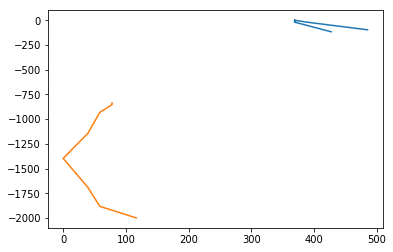

In [0]:
plot_lis2(res[0][1])

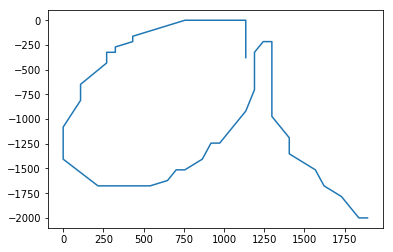

In [0]:
plot_lis2(res[1][1])

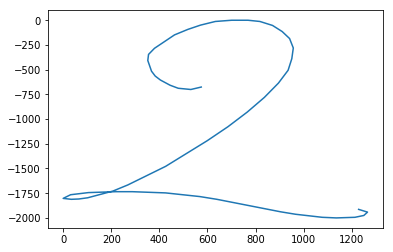

In [0]:
plot_lis2(res[2][1])

In [0]:
ids2names(res[1][0])

['a']

In [0]:
ids2names(res[2][0])

['2']

In [0]:
syms, stroke = fac.subsc_one(15, 58)

In [0]:
ids2names(syms)

['n', '_', 'k']

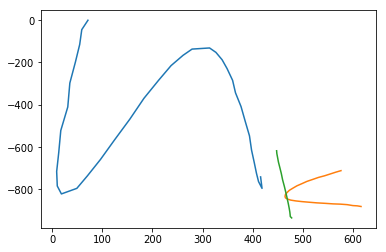

In [0]:
plot_lis2(stroke)

In [0]:
sym1 = train_sym_labels[15]
sym2 = train_sym_labels[58]
lislis1 = train_strokes[15]
lislis2 = train_strokes[58]

In [0]:
syms, stroke = two_term(sym1, sym2, lislis1, lislis2)

In [0]:
ids2names(syms)

['n', 'k']

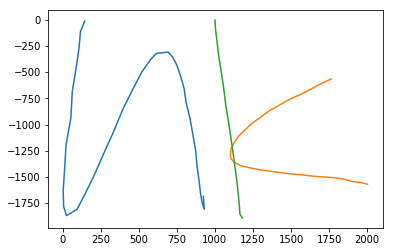

In [0]:
plot_lis2(stroke)

In [0]:
random.choices(range(5), k=7)

[2, 1, 4, 0, 1, 1, 1]

In [0]:
train_sym_char_mask = match_list(train_sym_labels, char_ids)

In [0]:
train_sym_char_indices = mask2indices(train_sym_char_mask)

In [0]:
len(train_sym_char_indices)

32632

In [0]:
len(train_strokes)

98289

In [0]:
train_sym_char_indices[11]

41

In [0]:
train_sym_char_indices[5]

15

In [0]:
id2sym[train_sym_labels[15]], id2sym[train_sym_labels[41]]

('n', 'x')

In [0]:
[id2sym[train_sym_labels[i]] for i in range (50, 60)]

['1', '<', '/', 'f', '(', '(', '-', '0', 'k', 'a']

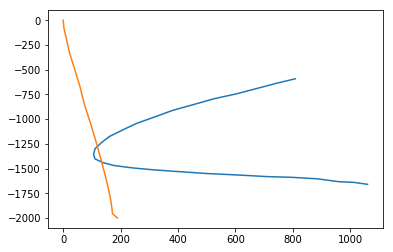

In [0]:
plot_lis2(train_strokes[58])

In [0]:
[(i, train_sym_char_indices[i]) for i in range(11, 20)]

[(11, 41),
 (12, 47),
 (13, 48),
 (14, 53),
 (15, 58),
 (16, 59),
 (17, 61),
 (18, 68),
 (19, 69)]

In [0]:
train_sym_char_indices[15]

58

In [0]:
random.uniform(-1.0, 1.0)

-0.8952728022981113

In [0]:
NOISE_MAG = 3

In [0]:
NORMALIZE_MAX

2000

In [0]:
id2sym[train_sym_labels[15]], id2sym[train_sym_labels[58]]

('n', 'k')

In [0]:
sym1 = train_sym_labels[15]
sym2 = train_sym_labels[58]
lislis1 = train_strokes[15]
lislis2 = train_strokes[58]

In [0]:
syms, stroke = subsc(sym1, sym2, lislis1, lislis2)

In [0]:
ids2names(syms)

['n', '_', 'k']

In [0]:
stroke[0][0]

array([68.01780232,  3.36916153])

In [0]:
stroke[0][0]

array([81.12149475,  0.        ])

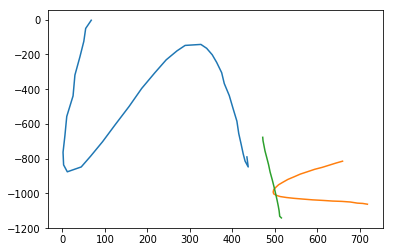

In [0]:
plot_lis2(stroke)

In [0]:
base1[0]

In [0]:
base1[0][:, 0].max()

416.6024608335174

In [0]:
scale_lis2(lislis1, base_scale)

In [0]:
train_strokes[58]

In [0]:
train_stroke_nom[15]

In [0]:
len(train_sym_char_mask)

98289

In [0]:
mask2indices(train_sym_char_mask[0:5])

[0, 3]

In [0]:
train_sym_char_mask[0:5]

[True, False, False, True, False]

In [0]:
train_sym_labels[0:5]

[61, 88, 6, 103, 37]

In [0]:
train_sym_raw_list[1]

{'path': 'Train/isolatedTest2012/both7024.inkml',
 'strokes': ['9.67412 15.9702, 9.6982 16.0023, 9.75839 16.1186, 9.79851 16.231, 9.81456 16.3353, 9.8266 16.4797, 9.80654 16.5881, 9.75437 16.6804, 9.69017 16.7606, 9.64202 16.8128'],
 'symbol': ')'}

In [0]:
id2sym[37]

'3'

In [0]:
train_sym_chars = mask_list(train_sym_labels, train_sym_char_mask)

In [0]:
ids2names(train_sym_chars[0:5])

['\\alpha', 'e', 'x', 'x', 'k']

In [0]:
5 in set([1, 2, 3])

False

In [0]:
# names2id(char_names)
names2id(num_names)

[8, 90, 65, 37, 68, 91, 66, 38, 10, 92]

In [0]:
train_sym_labels[0:2]

[61, 88]

In [0]:
mask_list(num_names, [False, True, True, False, False, False, False, False, False, False])

['1', '2']

In [0]:
char_name[0][0]

'\\'

In [0]:
valid_raw_list = get_and_load("crohme2019_fixed_valid_tokenized.pkl.gz")

Copying gs://karino2-tegashiki/dataset/crohme2019_fixed_valid_tokenized.pkl.gz...
/ [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation completed over 1 objects/1.2 MiB.                                      


In [0]:
[tup[3] for tup in valid_raw_list[0:100]]

'\theta'

In [0]:
(np.array(train_lens)<500).sum()

8131

In [0]:
(np.array(train_lens)>=500).sum()

1731